In [1]:
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xarray as xr
from dateutil.relativedelta import relativedelta


from my_functions import read_obsfcstana_extend_datetime
from my_functions import read_obsfcstana

In [2]:
expt_name = 'DAv7_M36_MULTI_type_13_comb_fp_scaled' #'LS_DAv8_M36'

start_date = datetime(2015, 4, 1)
end_date = datetime(2021, 4, 1)

start_date_str = start_date.strftime('%Y%m%d')
end_date_str = end_date.strftime('%Y%m%d')

In [3]:
root_directory = f'/discover/nobackup/projects/land_da/Experiment_archive/{expt_name}/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'

catdef_incr_list = []
srfexc_incr_list = []
rzexc_incr_list = []
total_incr_list = []
time_stamp_list = []

current_date = start_date

while current_date <= end_date:
    year_month_directory = os.path.join(root_directory, 
                                        f"Y{current_date.year}", 
                                        f"M{current_date.month:02d}")
    print(year_month_directory)
    for filename in sorted(os.listdir(year_month_directory)):
        if filename.endswith('.nc4') and not filename.endswith('z.nc4') and filename.startswith(f'{expt_name}.catch_progn_incr.2'):
            file_path = os.path.join(year_month_directory, filename)
            
            ds = xr.open_dataset(file_path)
            
            # Extract time_stamp
            time_stamp = ds['time_stamp']
            
            catdef_incr = ds['CATDEF_INCR']
            srfexc_incr = ds['SRFEXC_INCR']
            rzexc_incr = ds['RZEXC_INCR']
            
            total_incr = srfexc_incr + rzexc_incr - catdef_incr
                       
            time_stamp_list.append(time_stamp)    
            catdef_incr_list.append(catdef_incr)
            srfexc_incr_list.append(srfexc_incr)
            rzexc_incr_list.append(rzexc_incr)
            total_incr_list.append(total_incr)

            ds.close()
    current_date += relativedelta(months=1)

/discover/nobackup/projects/land_da/Experiment_archive/DAv7_M36_MULTI_type_13_comb_fp_scaled/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/Y2015/M04


KeyboardInterrupt: 

In [4]:
# Concatenate the sfmc_increment values along the time dimension
print('working on catdef_incr')
catdef_incr_concat = xr.concat(catdef_incr_list, dim='time')
print('working on srfexc_incr')
srfexc_incr_concat = xr.concat(srfexc_incr_list, dim='time')
print('working on catdef_incr')
rzexc_incr_concat = xr.concat(rzexc_incr_list, dim='time')
print('working on total_incr')
total_incr_concat = xr.concat(total_incr_list, dim='time')
print('working on time_stamp_concat')
time_stamp_concat = xr.concat(time_stamp_list, dim='time')

working on catdef_incr
working on srfexc_incr
working on catdef_incr
working on total_incr
working on time_stamp_concat


In [5]:
np.savez(f'{expt_name}_{start_date_str}_{end_date_str}catch_progn_incr_concat.npz',
         catdef_incr_concat=catdef_incr_concat,
         srfexc_incr_concat=srfexc_incr_concat,
         rzexc_incr_concat=rzexc_incr_concat,
         total_incr_concat=total_incr_concat,
         time_stamp_concat=time_stamp_concat)

In [6]:
data = np.load(f'{expt_name}_{start_date_str}_{end_date_str}_increments_concat.npz')
sfmc_increment_concat = data['sfmc_increment_concat']
rzmc_increment_concat = data['rzmc_increment_concat']
prmc_increment_concat = data['prmc_increment_concat']

In [7]:
# Define the thresholds and their corresponding labels
thresholds = [0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
labels = [f'Threshold: {threshold}\n Number of surface SM increments' for threshold in thresholds]

# Initialize dictionaries to store results
incremented_values = {}
cnt_sfmc_increment = {}
mean_sfmc_increment = {}
std_sfmc_increment = {}

# Perform calculations for each threshold
for threshold in thresholds:
    key = f'{threshold:.5f}'.split('.')[1].rstrip('0')  # Extract the fractional part and remove trailing zeros
    incremented_values[key] = (sfmc_increment_concat < -threshold) | (sfmc_increment_concat > threshold)
    cnt_sfmc_increment[key] = np.sum(incremented_values[key], axis=0)
    mean_sfmc_increment[key] = np.nanmean(np.where(incremented_values[key], sfmc_increment_concat, np.nan), axis=0)
    std_sfmc_increment[key] = np.nanstd(np.where(incremented_values[key], sfmc_increment_concat, np.nan), axis=0)

# Define the output file name
output_file = f'{expt_name}_{start_date_str}_{end_date_str}_incr_stats_test.npz'

# Remove the existing file if it exists
if os.path.exists(output_file):
    os.remove(output_file)

# Save the data to a file
try:
    np.savez(output_file,
             **{f'incremented_values_{key}': incremented_values[key] for key in incremented_values},
             **{f'cnt_sfmc_increment_{key}': cnt_sfmc_increment[key] for key in cnt_sfmc_increment},
             **{f'mean_sfmc_increment_{key}': mean_sfmc_increment[key] for key in mean_sfmc_increment},
             **{f'std_sfmc_increment_{key}': std_sfmc_increment[key] for key in std_sfmc_increment})
    print(f"Data successfully saved to {output_file}")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

/gpfsm/dnb34/tdirs/batch/slurm.44289537.amfox/ipykernel_20674/1605444861.py:16: RuntimeWarning: Mean of empty slice
  mean_sfmc_increment[key] = np.nanmean(np.where(incremented_values[key], sfmc_increment_concat, np.nan), axis=0)
/home/amfox/.conda/envs/diag/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Data successfully saved to DAv7_M36_MULTI_type_13_comb_fp_scaled_20150401_20210401_catch_progn_incr_stats_test.npz


In [15]:
data = np.load(f'{expt_name}_{start_date_str}_{end_date_str}catch_progn_incr_concat.npz')

srfexc_incr_concat = data['srfexc_incr_concat']

In [16]:
# Define the thresholds and their corresponding labels
thresholds = [0.0, 10.0e-7, 0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
labels = [f'Threshold: {threshold}\n Number of surface SM increments' for threshold in thresholds]

# Initialize dictionaries to store results
incremented_values_srfexc = {}
cnt_srfexc_increment = {}
mean_srfexc_increment = {}
std_srfexc_increment = {}

# Perform calculations for each threshold
for threshold in thresholds:
    key = f'{threshold:.5f}'.split('.')[1].rstrip('0')  # Extract the fractional part and remove trailing zeros
    incremented_values_srfexc[key] = (srfexc_incr_concat < -threshold) | (srfexc_incr_concat > threshold)
    cnt_srfexc_increment[key] = np.sum(incremented_values_srfexc[key], axis=0)
    mean_srfexc_increment[key] = np.nanmean(np.where(incremented_values_srfexc[key], srfexc_incr_concat, np.nan), axis=0)
    std_srfexc_increment[key] = np.nanstd(np.where(incremented_values_srfexc[key], srfexc_incr_concat, np.nan), axis=0)

# Define the output file name
output_file_srfexc = f'{expt_name}_{start_date_str}_{end_date_str}_catch_progn_incr_stats_test.npz'

# Remove the existing file if it exists
if os.path.exists(output_file_srfexc):
    os.remove(output_file_srfexc)

# Save the data to a file
try:
    np.savez(output_file_srfexc,
             **{f'incremented_values_srfexc_{key}': incremented_values_srfexc[key] for key in incremented_values_srfexc},
             **{f'cnt_srfexc_increment_{key}': cnt_srfexc_increment[key] for key in cnt_srfexc_increment},
             **{f'mean_srfexc_increment_{key}': mean_srfexc_increment[key] for key in mean_srfexc_increment},
             **{f'std_srfexc_increment_{key}': std_srfexc_increment[key] for key in std_srfexc_increment})
    print(f"Data successfully saved to {output_file_srfexc}")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

/gpfsm/dnb34/tdirs/batch/slurm.44294617.amfox/ipykernel_18264/1872852647.py:16: RuntimeWarning: Mean of empty slice
  mean_srfexc_increment[key] = np.nanmean(np.where(incremented_values_srfexc[key], srfexc_incr_concat, np.nan), axis=0)


Data successfully saved to DAv7_M36_MULTI_type_13_comb_fp_scaled_20150401_20210401_catch_progn_incr_stats_test.npz


In [3]:
from mapper_functions import plot_global_tight_pcm

ds = xr.open_dataset('DAv7_M36.inst3_1d_lndfcstana_Nt.20150901.nc4')
lon = ds['lon']
lat = ds['lat']
n_tile = len(lat)

Keys in the loaded .npz file: ['incremented_values_00005', 'incremented_values_0001', 'incremented_values_00015', 'incremented_values_0002', 'incremented_values_00025', 'incremented_values_0003', 'incremented_values_00035', 'incremented_values_0004', 'incremented_values_00045', 'incremented_values_0005', 'cnt_sfmc_increment_00005', 'cnt_sfmc_increment_0001', 'cnt_sfmc_increment_00015', 'cnt_sfmc_increment_0002', 'cnt_sfmc_increment_00025', 'cnt_sfmc_increment_0003', 'cnt_sfmc_increment_00035', 'cnt_sfmc_increment_0004', 'cnt_sfmc_increment_00045', 'cnt_sfmc_increment_0005', 'mean_sfmc_increment_00005', 'mean_sfmc_increment_0001', 'mean_sfmc_increment_00015', 'mean_sfmc_increment_0002', 'mean_sfmc_increment_00025', 'mean_sfmc_increment_0003', 'mean_sfmc_increment_00035', 'mean_sfmc_increment_0004', 'mean_sfmc_increment_00045', 'mean_sfmc_increment_0005', 'std_sfmc_increment_00005', 'std_sfmc_increment_0001', 'std_sfmc_increment_00015', 'std_sfmc_increment_0002', 'std_sfmc_increment_0002

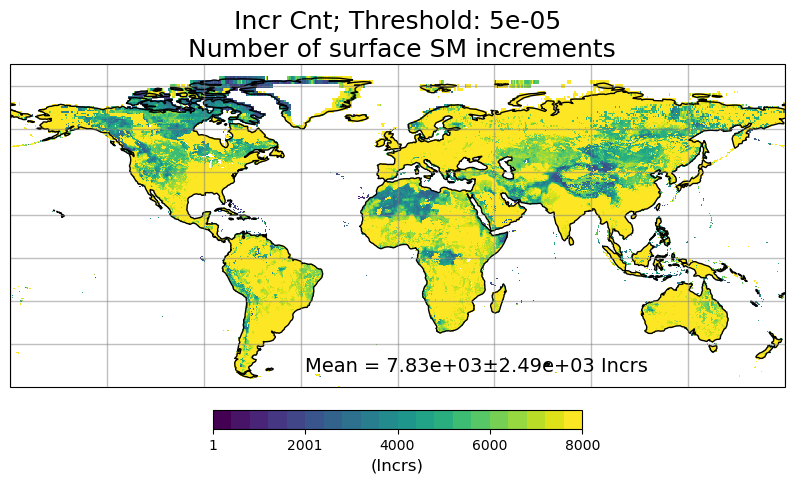

Trying to access key: cnt_sfmc_increment_0001


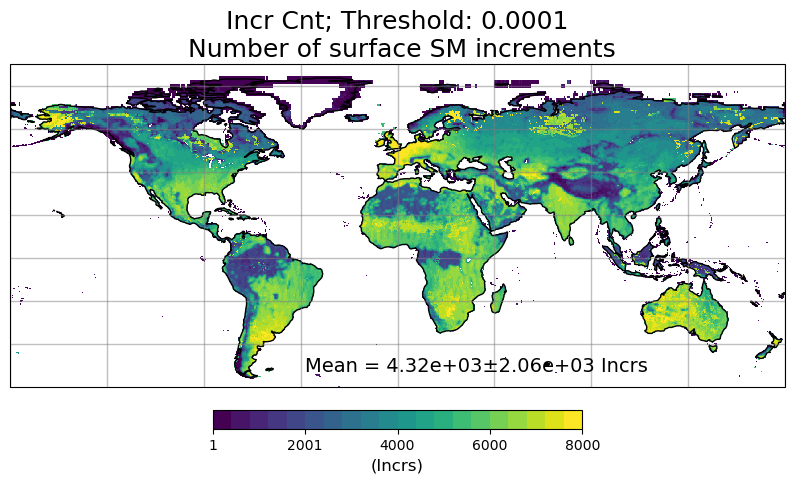

Trying to access key: cnt_sfmc_increment_00015


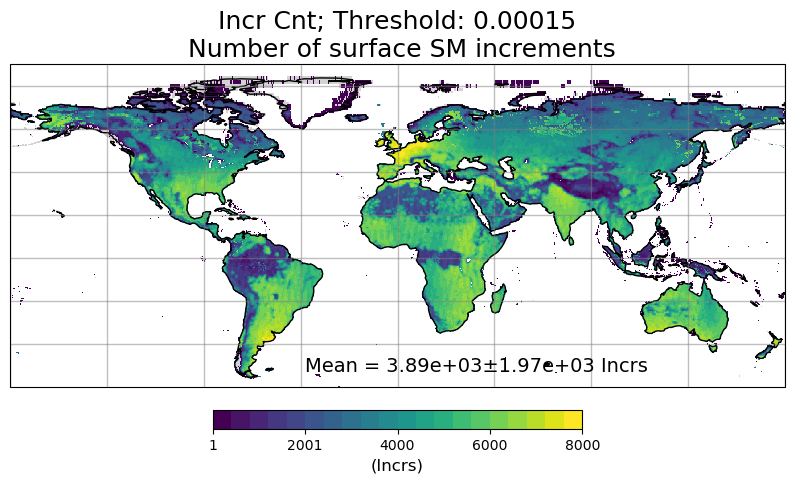

Trying to access key: cnt_sfmc_increment_0002


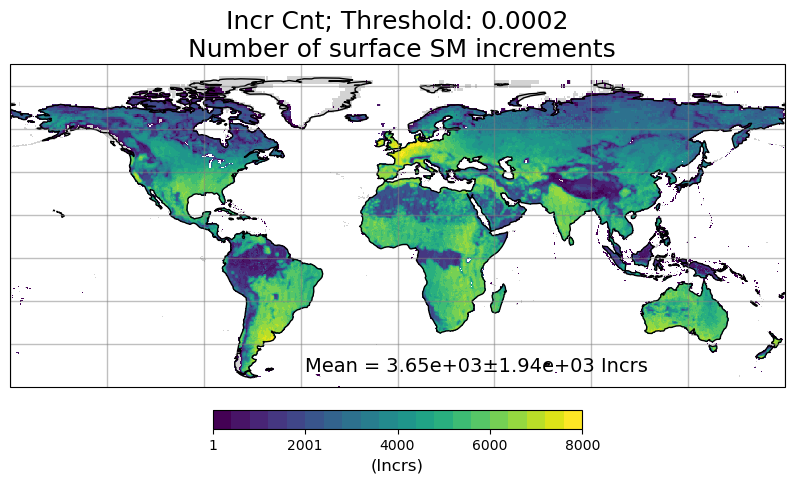

Trying to access key: cnt_sfmc_increment_00025


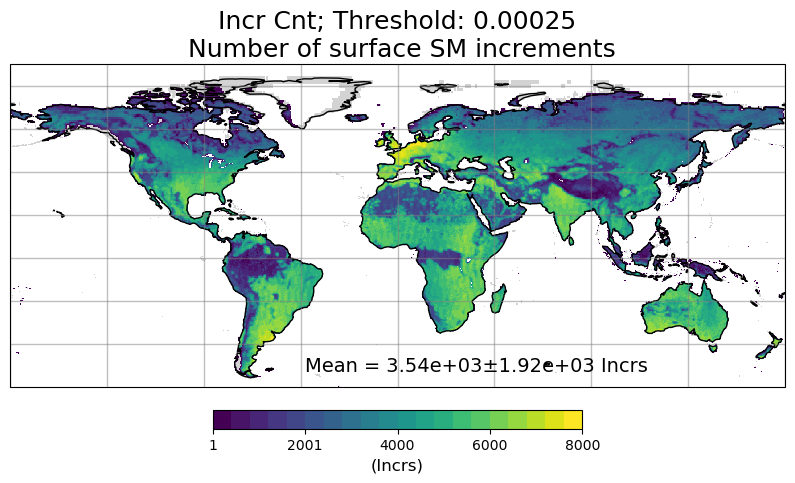

Trying to access key: cnt_sfmc_increment_0003


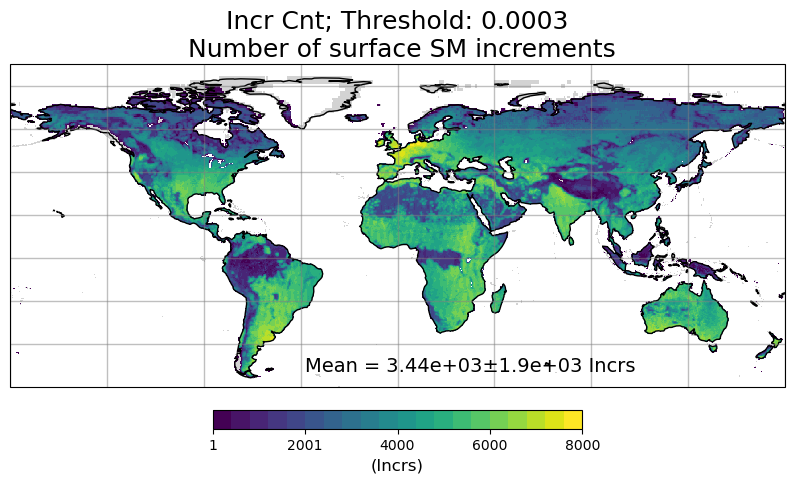

Trying to access key: cnt_sfmc_increment_00035


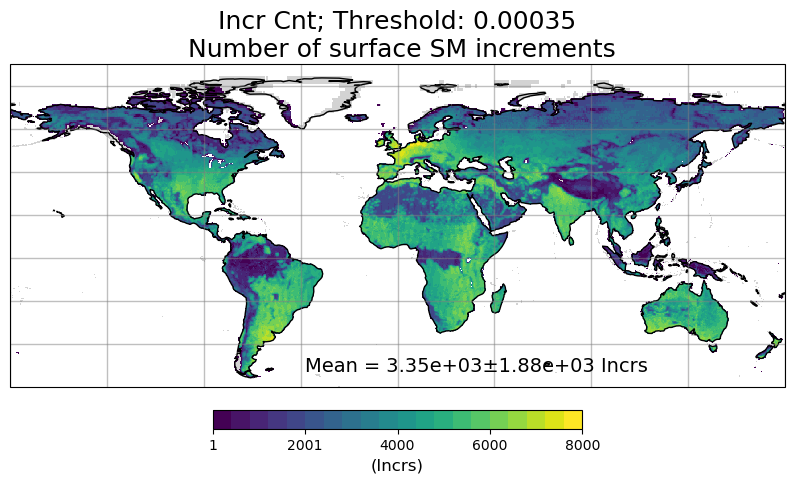

Trying to access key: cnt_sfmc_increment_0004


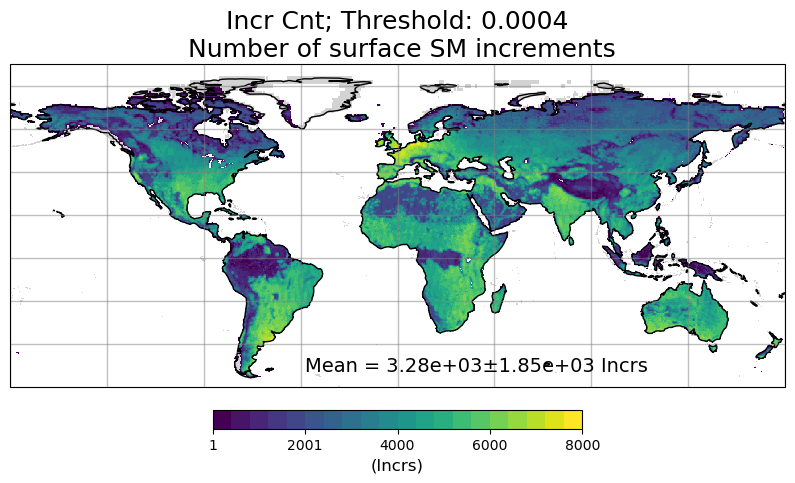

Trying to access key: cnt_sfmc_increment_00045


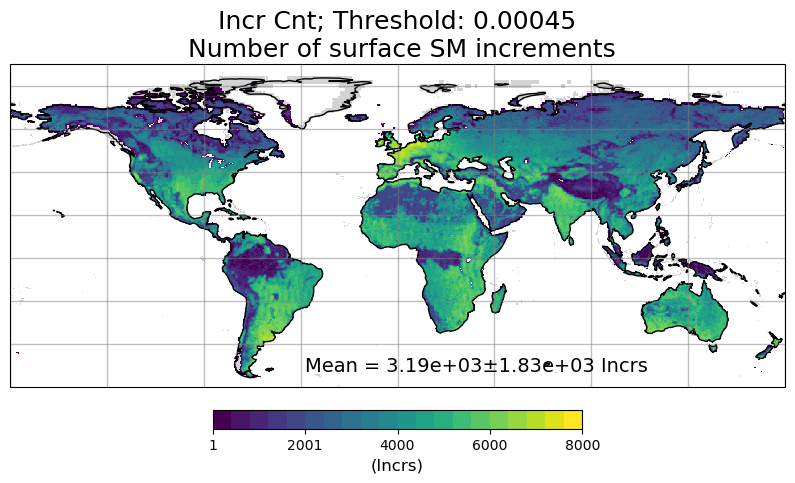

Trying to access key: cnt_sfmc_increment_0005


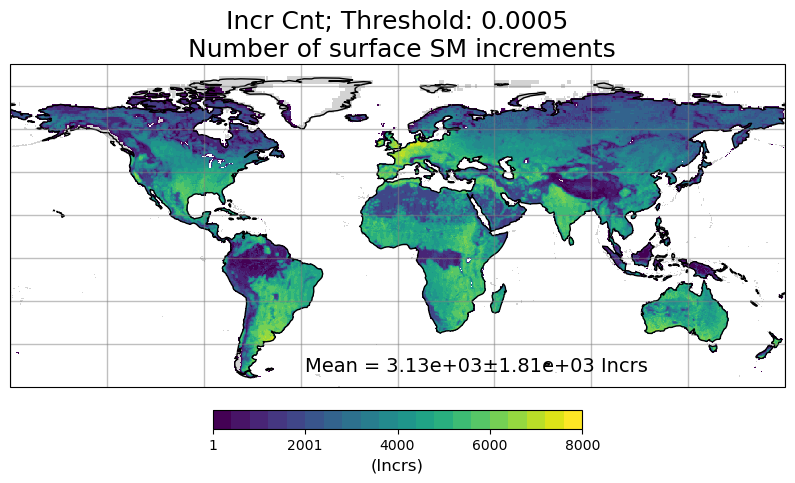

In [4]:
# Define the thresholds and their corresponding labels
thresholds = [0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
labels = [f'Threshold: {threshold}\n Number of surface SM increments' for threshold in thresholds]

# Define the output file name
output_file = f'{expt_name}_{start_date_str}_{end_date_str}_incr_stats_test.npz'

# Load the data from the .npz file
data = np.load(output_file)

# Print the keys in the loaded data for debugging
print("Keys in the loaded .npz file:", data.files)

obarray = np.empty([n_tile, 3])
obarray.fill(np.nan)
obarray[:, 1] = lon
obarray[:, 2] = lat

# Plotting
for threshold, label in zip(thresholds, labels):
    key = f'{threshold:.5f}'.split('.')[1].rstrip('0')  # Extract the fractional part and remove trailing zeros
    print(f"Trying to access key: cnt_sfmc_increment_{key}")  # Debugging print statement
    obarray[:, 0] = data[f'cnt_sfmc_increment_{key}']  # or any other array you want to plot
    plot_global_tight_pcm(obarray, False, True, f'Incr Cnt; {label}', 'Incrs', 1, 8000)

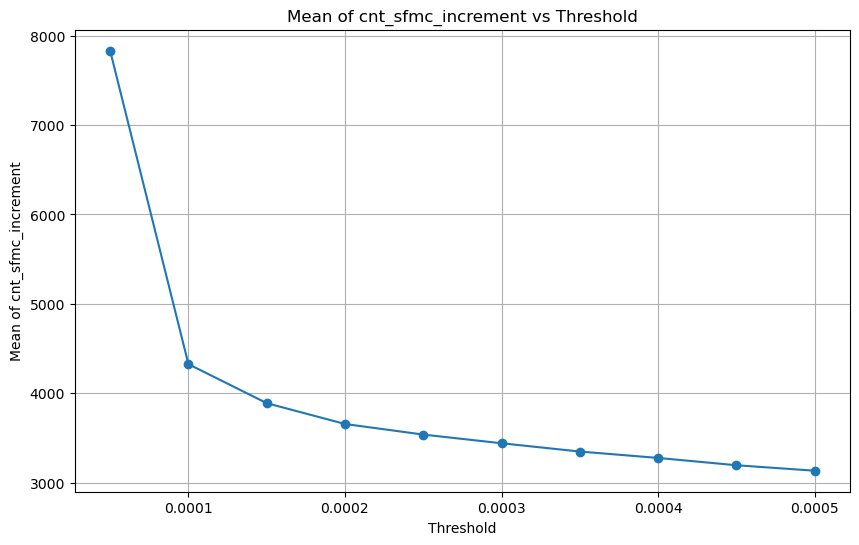

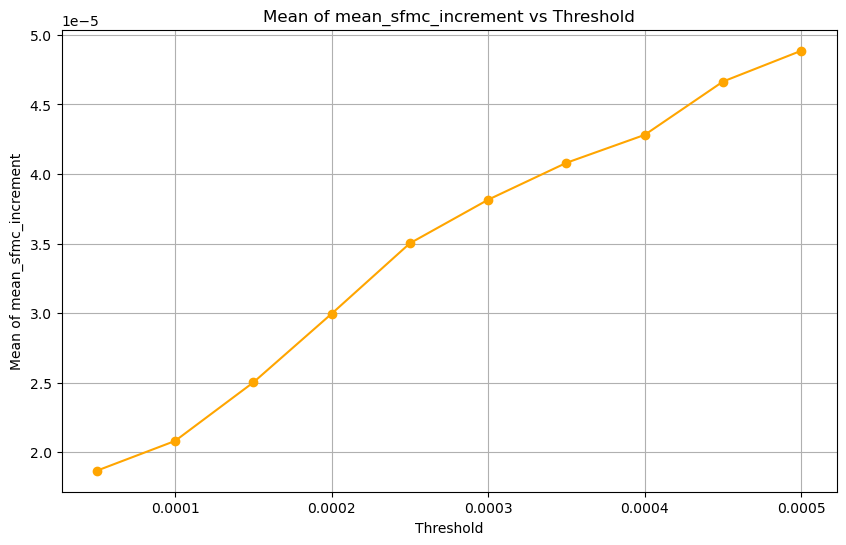

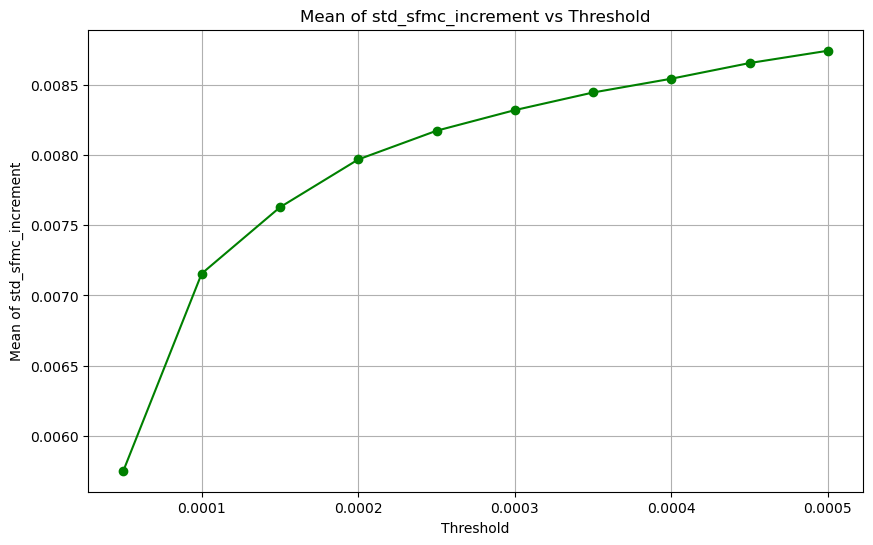

In [5]:
# Calculate the mean of cnt_sfmc_increment for each threshold
mean_cnt_sfmc_increment = [np.nanmean(data[f'cnt_sfmc_increment_{f"{threshold:.5f}".split(".")[1].rstrip("0")}']) for threshold in thresholds]
mean_mean_sfmc_increment = [np.nanmean(data[f'mean_sfmc_increment_{f"{threshold:.5f}".split(".")[1].rstrip("0")}']) for threshold in thresholds]
mean_std_sfmc_increment = [np.nanmean(data[f'std_sfmc_increment_{f"{threshold:.5f}".split(".")[1].rstrip("0")}']) for threshold in thresholds]

# Plot the mean of cnt_sfmc_increment against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_cnt_sfmc_increment, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Mean of cnt_sfmc_increment')
plt.title('Mean of cnt_sfmc_increment vs Threshold')
plt.grid(True)
plt.savefig('mean_cnt_sfmc_increment_vs_threshold.png')
plt.show()

# Plot the mean of mean_sfmc_increment against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_mean_sfmc_increment, marker='o', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean of mean_sfmc_increment')
plt.title('Mean of mean_sfmc_increment vs Threshold')
plt.grid(True)
plt.savefig('mean_mean_sfmc_increment_vs_threshold.png')
plt.show()

# Plot the mean of std_sfmc_increment against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_std_sfmc_increment, marker='o', color='green')
plt.xlabel('Threshold')
plt.ylabel('Mean of std_sfmc_increment')
plt.title('Mean of std_sfmc_increment vs Threshold')
plt.grid(True)
plt.savefig('mean_std_sfmc_increment_vs_threshold.png')
plt.show()

In [6]:
# Define the thresholds and their corresponding labels
thresholds = [0.0, 10.0e-7, 0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
labels = [f'Threshold: {threshold}\n Number of srfexc increments' for threshold in thresholds]

# Define the output file name
output_file = f'{expt_name}_{start_date_str}_{end_date_str}_catch_progn_incr_stats_test.npz'

# Load the data from the .npz file
data = np.load(output_file)

test = data['cnt_srfexc_increment_']

print(test.shape)

(112573,)


Keys in the loaded .npz file: ['incremented_values_srfexc_', 'incremented_values_srfexc_00005', 'incremented_values_srfexc_0001', 'incremented_values_srfexc_00015', 'incremented_values_srfexc_0002', 'incremented_values_srfexc_00025', 'incremented_values_srfexc_0003', 'incremented_values_srfexc_00035', 'incremented_values_srfexc_0004', 'incremented_values_srfexc_00045', 'incremented_values_srfexc_0005', 'cnt_srfexc_increment_', 'cnt_srfexc_increment_00005', 'cnt_srfexc_increment_0001', 'cnt_srfexc_increment_00015', 'cnt_srfexc_increment_0002', 'cnt_srfexc_increment_00025', 'cnt_srfexc_increment_0003', 'cnt_srfexc_increment_00035', 'cnt_srfexc_increment_0004', 'cnt_srfexc_increment_00045', 'cnt_srfexc_increment_0005', 'mean_srfexc_increment_', 'mean_srfexc_increment_00005', 'mean_srfexc_increment_0001', 'mean_srfexc_increment_00015', 'mean_srfexc_increment_0002', 'mean_srfexc_increment_00025', 'mean_srfexc_increment_0003', 'mean_srfexc_increment_00035', 'mean_srfexc_increment_0004', 'mea

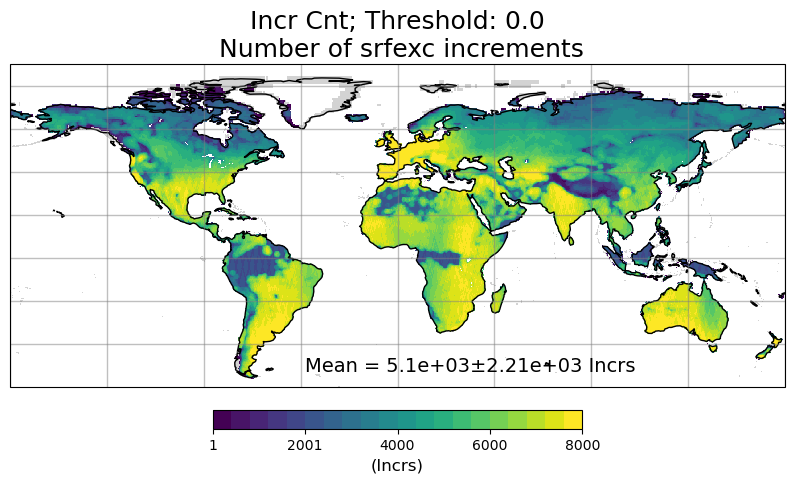

Trying to access key: cnt_sfmc_increment_
 Saving figure as Incr_Cnt_Threshold_1e_06_Number_of_srfexc_increments.png 



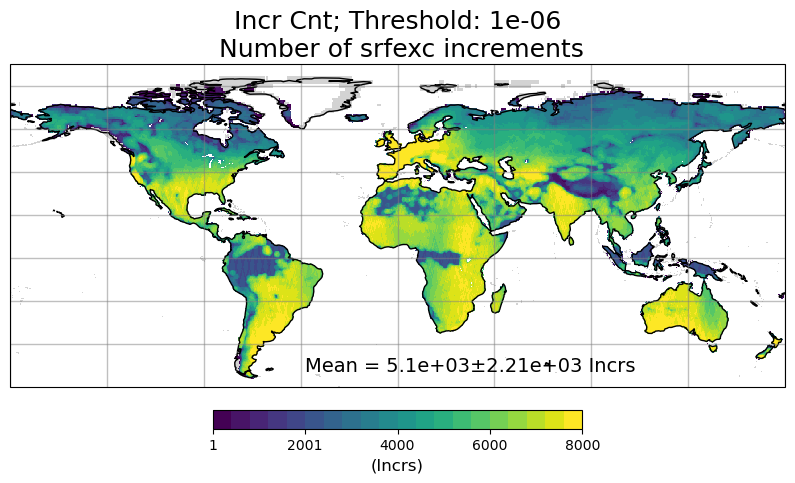

Trying to access key: cnt_sfmc_increment_00005
 Saving figure as Incr_Cnt_Threshold_5e_05_Number_of_srfexc_increments.png 



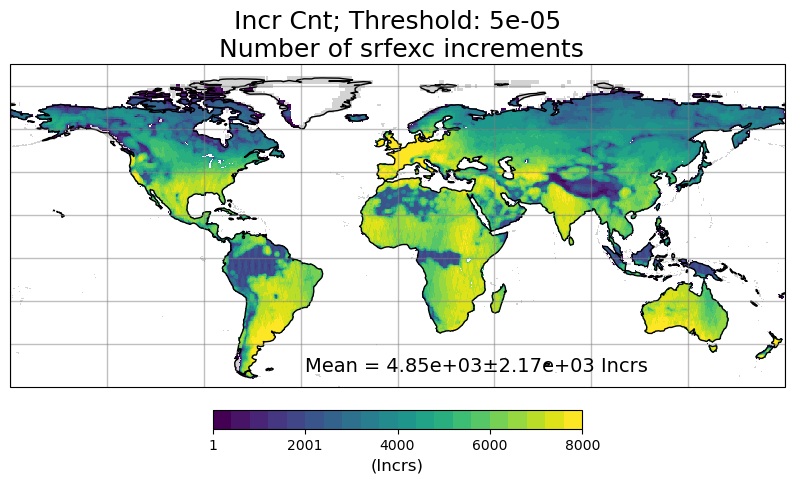

Trying to access key: cnt_sfmc_increment_0001
 Saving figure as Incr_Cnt_Threshold_0_0001_Number_of_srfexc_increments.png 



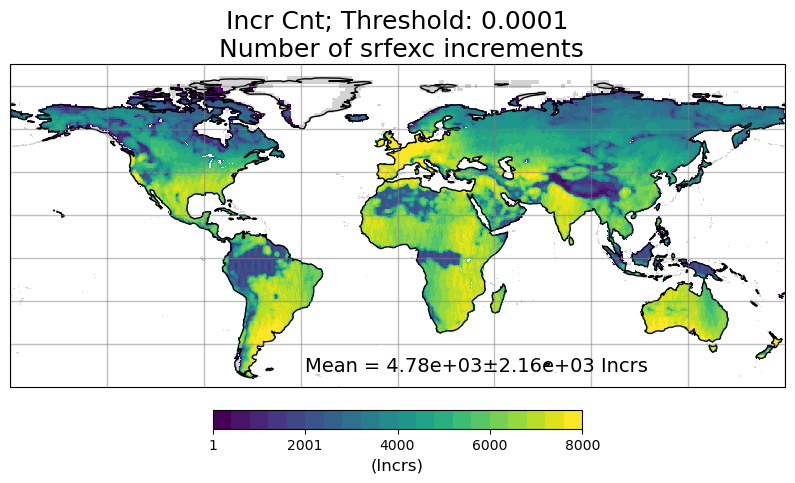

Trying to access key: cnt_sfmc_increment_00015
 Saving figure as Incr_Cnt_Threshold_0_00015_Number_of_srfexc_increments.png 



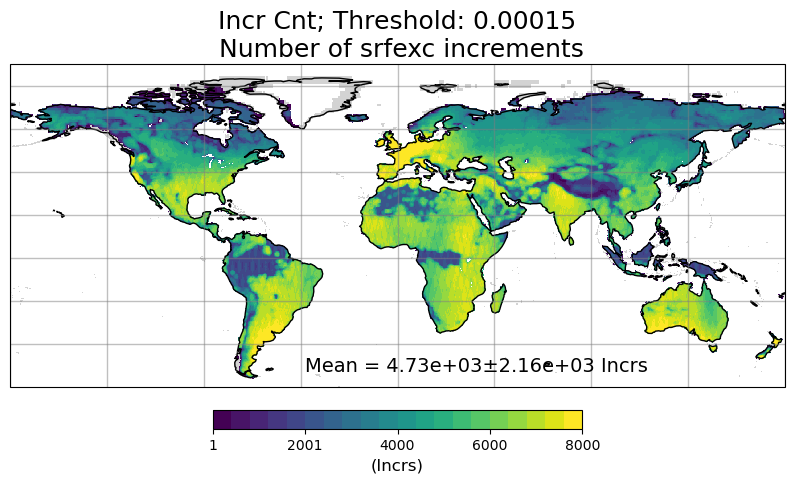

Trying to access key: cnt_sfmc_increment_0002
 Saving figure as Incr_Cnt_Threshold_0_0002_Number_of_srfexc_increments.png 



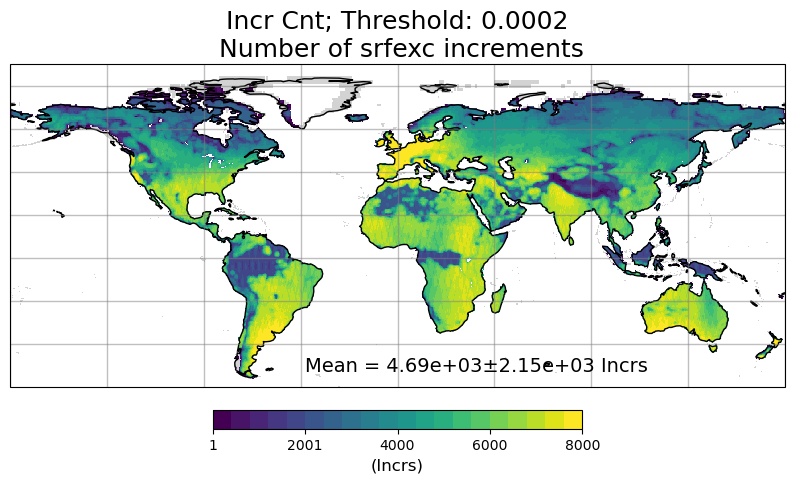

Trying to access key: cnt_sfmc_increment_00025
 Saving figure as Incr_Cnt_Threshold_0_00025_Number_of_srfexc_increments.png 



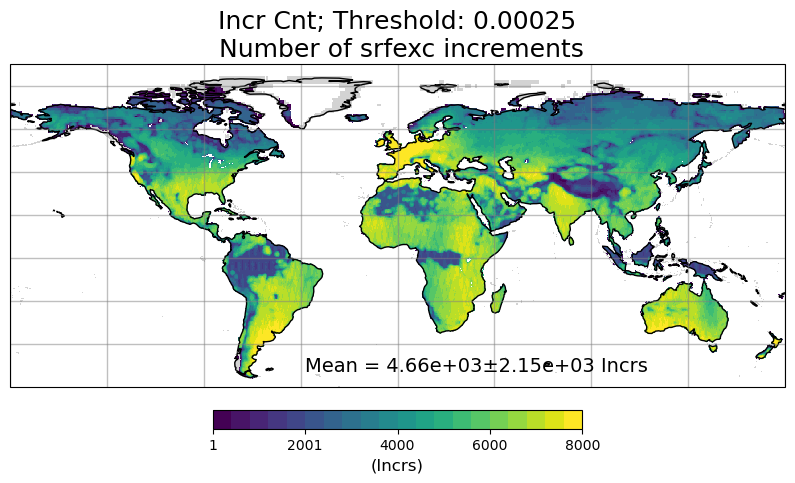

Trying to access key: cnt_sfmc_increment_0003
 Saving figure as Incr_Cnt_Threshold_0_0003_Number_of_srfexc_increments.png 



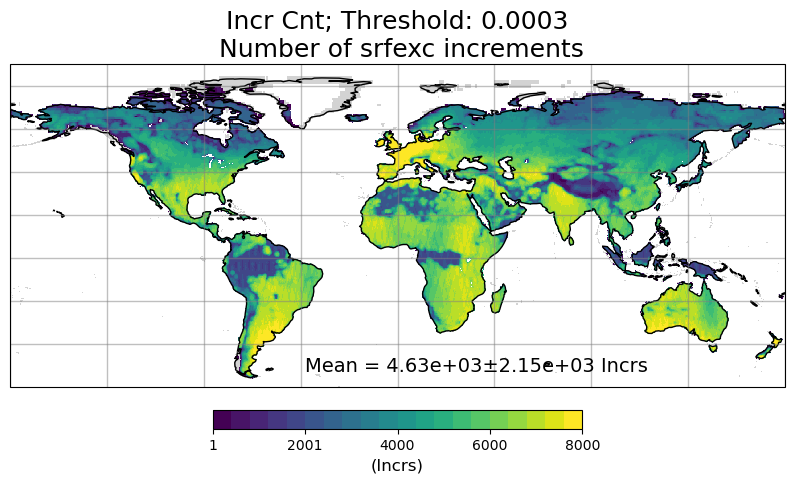

Trying to access key: cnt_sfmc_increment_00035
 Saving figure as Incr_Cnt_Threshold_0_00035_Number_of_srfexc_increments.png 



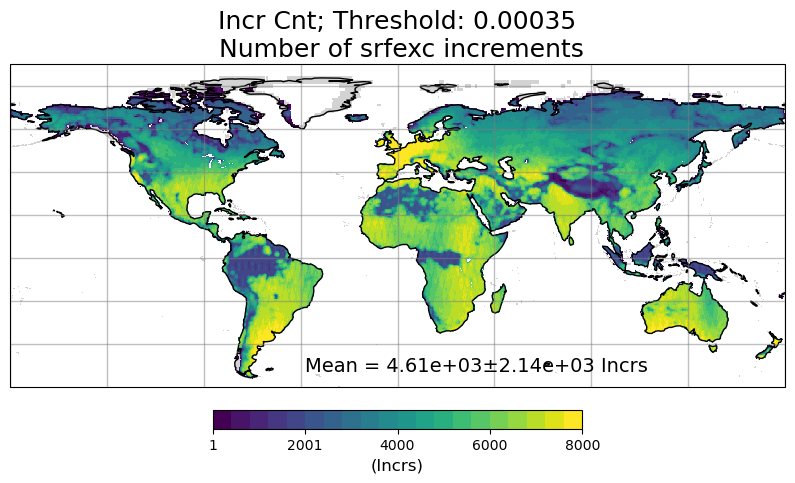

Trying to access key: cnt_sfmc_increment_0004
 Saving figure as Incr_Cnt_Threshold_0_0004_Number_of_srfexc_increments.png 



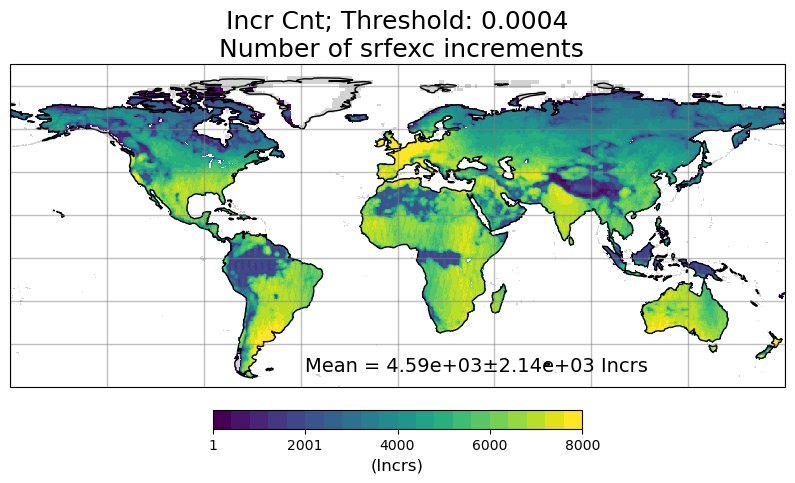

Trying to access key: cnt_sfmc_increment_00045
 Saving figure as Incr_Cnt_Threshold_0_00045_Number_of_srfexc_increments.png 



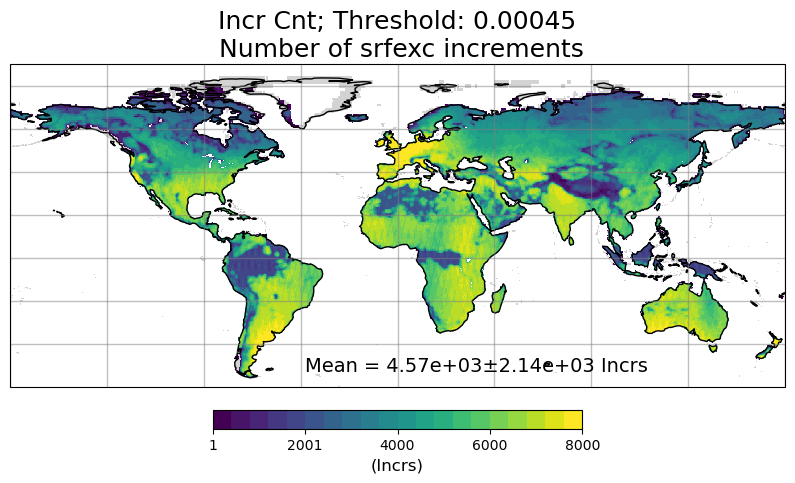

Trying to access key: cnt_sfmc_increment_0005
 Saving figure as Incr_Cnt_Threshold_0_0005_Number_of_srfexc_increments.png 



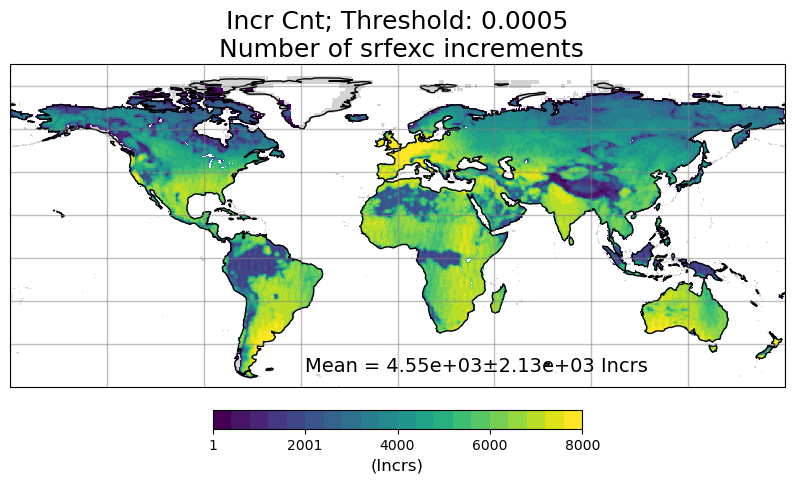

In [7]:
# Print the keys in the loaded data for debugging
print("Keys in the loaded .npz file:", data.files)

obarray = np.empty([n_tile, 3])
obarray.fill(np.nan)
obarray[:, 1] = lon
obarray[:, 2] = lat

# Plotting
for threshold, label in zip(thresholds, labels):
    key = f'{threshold:.5f}'.split('.')[1].rstrip('0')  # Extract the fractional part and remove trailing zeros
    print(f"Trying to access key: cnt_sfmc_increment_{key}")  # Debugging print statement
    obarray[:, 0] = data[f'cnt_srfexc_increment_{key}']  # or any other array you want to plot
    #obarray[:, 0] = obarray[:, 0] / (365.25*6)
    plot_global_tight_pcm(obarray, True, True, f'Incr Cnt; {label}', 'Incrs', 1, 8000)

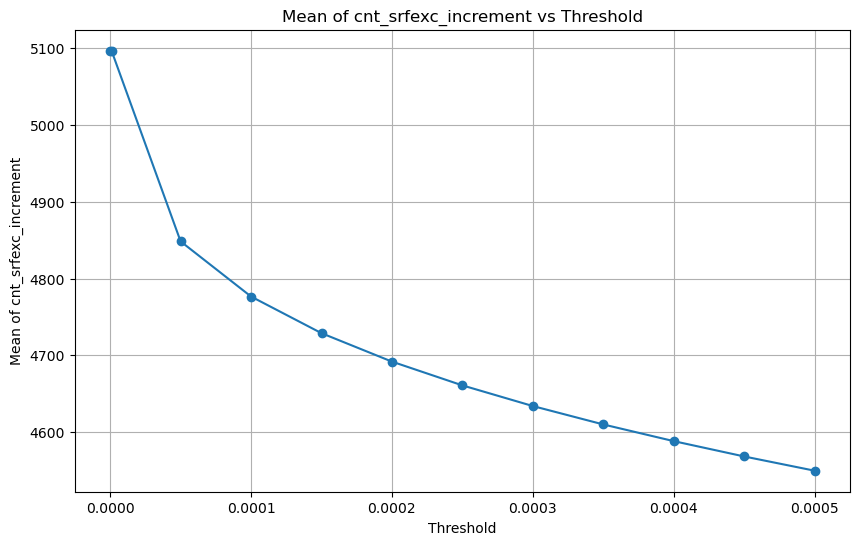

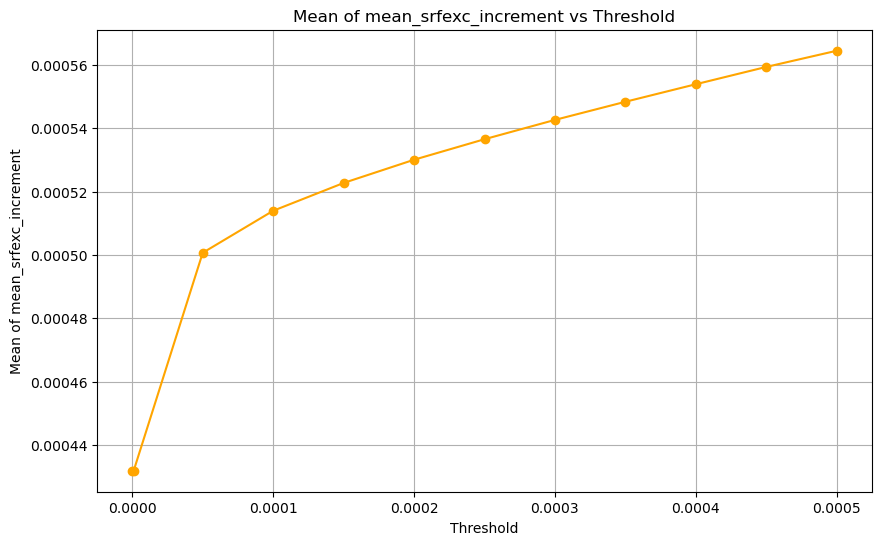

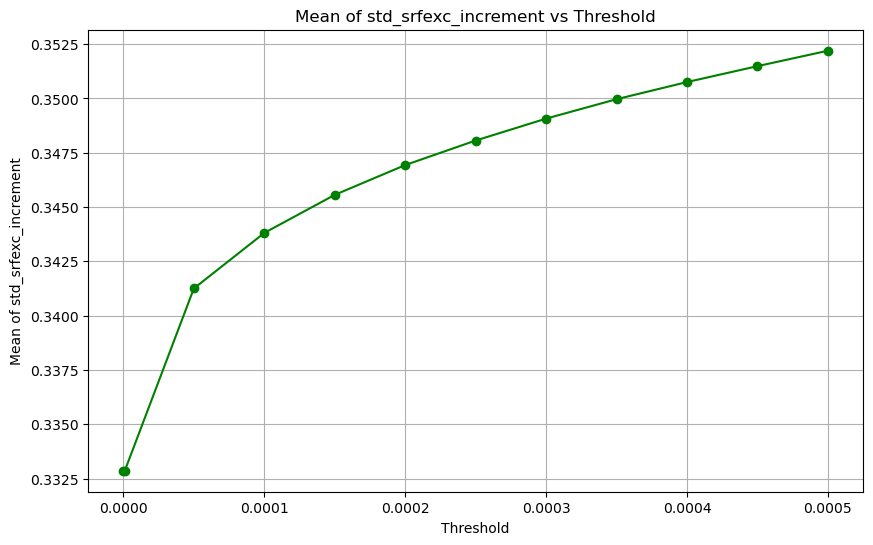

In [8]:
# Calculate the mean of cnt_sfmc_increment for each threshold
mean_cnt_srfexc_increment = [np.nanmean(data[f'cnt_srfexc_increment_{f"{threshold:.5f}".split(".")[1].rstrip("0")}']) for threshold in thresholds]
mean_mean_srfexc_increment = [np.nanmean(data[f'mean_srfexc_increment_{f"{threshold:.5f}".split(".")[1].rstrip("0")}']) for threshold in thresholds]
mean_std_srfexc_increment = [np.nanmean(data[f'std_srfexc_increment_{f"{threshold:.5f}".split(".")[1].rstrip("0")}']) for threshold in thresholds]

# Plot the mean of cnt_sfmc_increment against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_cnt_srfexc_increment, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Mean of cnt_srfexc_increment')
plt.title('Mean of cnt_srfexc_increment vs Threshold')
plt.grid(True)
plt.savefig('mean_cnt_srfexc_increment_vs_threshold.png')
plt.show()

# Plot the mean of mean_sfmc_increment against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_mean_srfexc_increment, marker='o', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean of mean_srfexc_increment')
plt.title('Mean of mean_srfexc_increment vs Threshold')
plt.grid(True)
plt.savefig('mean_mean_srfexc_increment_vs_threshold.png')
plt.show()

# Plot the mean of std_sfmc_increment against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_std_srfexc_increment, marker='o', color='green')
plt.xlabel('Threshold')
plt.ylabel('Mean of std_srfexc_increment')
plt.title('Mean of std_srfexc_increment vs Threshold')
plt.grid(True)
plt.savefig('mean_std_srfexc_increment_vs_threshold.png')
plt.show()